In [ ]:
# !pip install gymnasium
# !pip install pygame

#### Imports

In [1]:
# Configuraciones
from collections import defaultdict

# Las de siempre
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns
import time
from tqdm import tqdm

# Aprendizaje por Refuerzo
import gymnasium as gym  # https://gymnasium.farama.org/index.html

# Otras librerías útiles
# import pygame

# Conceptos Básicos

* Agente: Es la entidad que toma decisiones y realiza acciones en el entorno para lograr un objetivo.

* Entorno: Es el contexto en el que el agente toma decisiones y realiza acciones. Puede ser cualquier sistema que el agente esté tratando de aprender y mejorar.

* Episodio: Es un período completo de interacción entre el agente y el entorno, desde el inicio hasta que se alcanza un estado final.

* Estado: Es una situación específica en la que se encuentra el entorno en un momento dado.

* Recompensa: Es la retroalimentación que el agente recibe del entorno después de realizar una acción en un estado particular. Indica cuán buena o mala fue esa acción.

* Política: Es la estrategia o conjunto de reglas que el agente sigue para tomar decisiones en diferentes estados.

* Alpha (tasa de aprendizaje): Es cuánto el agente aprende de una nueva experiencia. Una tasa alta significa aprendizaje rápido, pero puede ser volátil.

* Gamma (descuento): Controla cuánto valoramos las recompensas futuras. Un valor alto prioriza las recompensas a largo plazo.

* Epsilon (exploración vs. explotación): Decide cuánto el agente elige acciones aleatorias en lugar de las aprendidas. A medida que disminuye, el agente tiende a elegir acciones que conoce mejor.

# Q- Learning

Q-Learning es un algoritmo de aprendizaje por refuerzo que permite a un agente aprender a tomar decisiones óptimas en un entorno desconocido. El agente mantiene una tabla (llamada tabla Q) que asigna un valor (Q-value) a cada par estado-acción. Estos valores representan la utilidad esperada de realizar una acción en un estado particular.

Durante la interacción con el entorno, el agente actualiza los Q-valores usando la fórmula de actualización Q, que tiene en cuenta las recompensas inmediatas y los Q-values futuros.

Con el tiempo, el agente aprende una política óptima al seleccionar las acciones con los Q-values más altos en cada estado. Q-Learning es efectivo para problemas de toma de decisiones secuenciales, como juegos o control de robots.

$$
Q[state,action]=Q[state,action]+α⋅(reward+γ⋅max(Q[new_state,:])−Q[state,action])
$$

## Del Punto A al Punto B

                                                        O----T

In [2]:
n_states = 6   # longitud del entorno
actions = ['left', 'right']     # acciones disponibles
epsilon = 0.9   # 'greedy policy': exploración vs explotación -> exploración
alpha = 0.1     # 'learning rate': nivel de 'confianza' del agente -> desconfiado, cauto
gamma = 0.9    # 'discount factor': si las recompensas disminuyen con el tiempo.
max_episodes = 13   # número máximo de episodios
fresh_time = 0.3    # tiempo de actualización entre episodios

In [3]:
def build_q_table(n_states, actions):
    table = pd.DataFrame(
        np.zeros((n_states, len(actions))),     # valores iniciales de la tabla Q
        columns=actions,
        )
    # print(table)
    return table

In [4]:
build_q_table(6, actions)

,left,right
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0


In [5]:
def choose_action(state, q_table):
    state_actions = q_table.iloc[state, :]
    if (np.random.uniform() > epsilon) or ((state_actions == 0).all()):  # non greedy, obligándolo a explorar
        action_name = np.random.choice(actions)
    else:   # greedy
        action_name = state_actions.idxmax()    # escoger la acción con el valor más alto
    return action_name


def get_env_feedback(S, A):
    # Interacción del agente con el entorno
    if A == 'right':  # Si te mueves a la derecha
        if S == n_states - 2:  # Y estabas en el penúltimo lugar (-1 es el último)
            S_ = 'terminal'
            R = 1  # recompensa
        else:
            S_ = S + 1
            R = 0
    else:   # izquierda
        R = 0
        if S == 0:
            S_ = S  # inicio
        else:
            S_ = S - 1
    return S_, R


def update_env(S, episode, step_counter):
    env_list = ['-']*(n_states-1) + ['T']   # '---------T'
    if S == 'terminal':
        interaction = 'Episode %s: total_steps = %s' % (episode +1, step_counter)
        print('\r{}'.format(interaction), end='')
        time.sleep(2)
        print('\r                                ', end='')
    else:
        env_list[S] = 'o'
        interaction = ''.join(env_list)
        print('\r{}'.format(interaction), end='')
        time.sleep(fresh_time)


def rl():
    # Aprendizaje por refuerzo (RL)
    q_table = build_q_table(n_states, actions)
    for episode in range(max_episodes):
        step_counter = 0
        S = 0
        is_terminated = False
        update_env(S, episode, step_counter)
        while not is_terminated:

            A = choose_action(S, q_table)  # Elegir A basada en S actual y QT
            S_, R = get_env_feedback(S, A)  # Obtener nuevo S y R
            q_predict = q_table.loc[S, A]
            if S_ != 'terminal':
                q_target = R + gamma * q_table.iloc[S_, :].max() # Lo que tiene y lo que quiere
                                                                 # Al principio, no sabe lo que quiere, será todo aleatorio
            else:
                q_target = R    
                is_terminated = True

            q_table.loc[S, A] += alpha * (q_target - q_predict) # Ajusta QT en base a sus "experiencias":
                                                                # Si la realidad es mejor de lo que esperaba, ajusta sus expectativas hacia arriba
                                                                # Si es peor, las ajusta hacia abajo.
            S = S_ 

            update_env(S, episode, step_counter+1)
            step_counter += 1
    return q_table

In [6]:
np.random.seed(5)

q_table = rl()
print('\r\nQ-table:\n')
q_table

                                
Q-table:



,left,right
0,0.000033,0.004770
1,0.000015,0.031412
2,0.000000,0.149428
3,0.010011,0.389009
4,0.048619,0.745813
5,0.000000,0.000000


## Gymnasium (Gym)

Gymnasium, anteriormente Gym, es una biblioteca de código abierto desarrollada por OpenAI que proporciona entornos de prueba estándar para experimentar con algoritmos de aprendizaje por refuerzo. Ofrece una variedad de entornos predefinidos, desde juegos simples hasta problemas complejos, permitiendo a los desarrolladores y científicos de datos entrenar y evaluar agentes de aprendizaje por refuerzo de manera consistente.

Gym facilita la experimentación y comparación de diferentes enfoques de aprendizaje por refuerzo al proporcionar un marco unificado para la creación y evaluación de entornos.

In [7]:
env_keys = gym.envs.registry.keys()

for key in env_keys:
    print(key)

print('------------------')
print('Total de entornos:', len(env_keys))

CartPole-v0
CartPole-v1
MountainCar-v0
MountainCarContinuous-v0
Pendulum-v1
Acrobot-v1
phys2d/CartPole-v0
phys2d/CartPole-v1
phys2d/Pendulum-v0
LunarLander-v2
LunarLanderContinuous-v2
BipedalWalker-v3
BipedalWalkerHardcore-v3
CarRacing-v2
Blackjack-v1
FrozenLake-v1
FrozenLake8x8-v1
CliffWalking-v0
Taxi-v3
tabular/Blackjack-v0
tabular/CliffWalking-v0
Reacher-v2
Reacher-v4
Pusher-v2
Pusher-v4
InvertedPendulum-v2
InvertedPendulum-v4
InvertedDoublePendulum-v2
InvertedDoublePendulum-v4
HalfCheetah-v2
HalfCheetah-v3
HalfCheetah-v4
Hopper-v2
Hopper-v3
Hopper-v4
Swimmer-v2
Swimmer-v3
Swimmer-v4
Walker2d-v2
Walker2d-v3
Walker2d-v4
Ant-v2
Ant-v3
Ant-v4
Humanoid-v2
Humanoid-v3
Humanoid-v4
HumanoidStandup-v2
HumanoidStandup-v4
GymV21Environment-v0
GymV26Environment-v0
------------------
Total de entornos: 51


# Blackjack

![](https://gymnasium.farama.org/_images/blackjack_AE_loop_dark.png)

## Funcionamiento

In [8]:
env = gym.make('Blackjack-v1',
            #    nat = False # Otorga recompensa extra si el jugador empieza con 21.
               sab = True, # Si el jugador tiene 21 y el dealer también, es un empate. http://www.incompleteideas.net/book/RLbook2020.pdf
            #    render_mode='human'
               )

env.reset()

((20, 3, 0), {})

In [9]:
from utils.env.blackjack import BlackjackEnv

env = BlackjackEnv()
env.reset()

((16, 4, False), {})

In [10]:
observation, info = env.reset(seed = 0)
print(observation[0], ': Jugador')
print(observation[1], ': Dealer')
print(observation[2], ': Hay algún as "utilizable"')

11 : Jugador
10 : Dealer
False : Hay algún as "utilizable"


In [11]:
# Elegimos una acción aleatoria
action = env.action_space.sample()

# 0 = stand (nos quedamos con el valor que tenemos)
# 1 = hit (pedimos una carta más)

action

0

In [12]:
observation, reward, terminated, truncated, info = env.step(action)

print(action, observation, terminated, reward)

0 (11, 19, False) True -1.0


## Agente

In [13]:
from utils.agent.blackjack import BlackjackAgent

In [14]:
learning_rate = 0.01 # alpha
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reducir la exploración con el tiempo
final_epsilon = 0.1

agent = BlackjackAgent(learning_rate = learning_rate,
                       initial_epsilon = start_epsilon,
                       epsilon_decay = epsilon_decay,
                       final_epsilon = final_epsilon,)

## Entrenamiento

In [15]:
env.reset()
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size = n_episodes)

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # actualizar al agente
        agent.update(obs, action, reward, terminated, next_obs)

        # actualizar si el entorno sigue funcionando
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:18<00:00, 5550.61it/s]


## Evaluación y Análisis

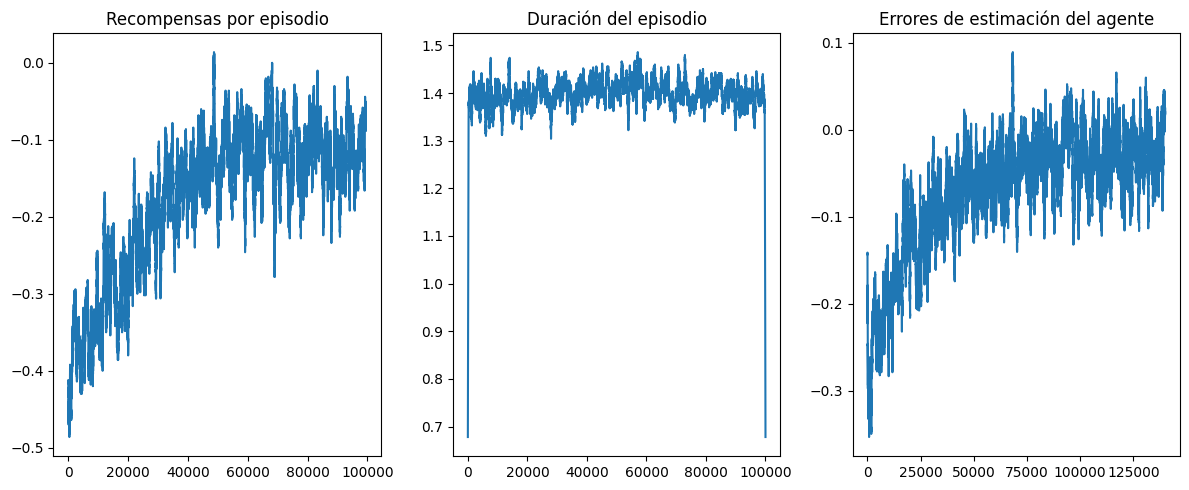

In [16]:
rolling_length = 500
fig, axs = plt.subplots(ncols = 3, figsize = (12, 5))
axs[0].set_title("Recompensas por episodio")
# calcular y asignar un promedio de los datos para obtener un gráfico mejor
reward_moving_average = (np.convolve(np.array(env.return_queue).flatten(),
                                     np.ones(rolling_length),
                                     mode = "valid") / rolling_length)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Duración del episodio")
length_moving_average = (np.convolve(np.array(env.length_queue).flatten(),
                                     np.ones(rolling_length),
                                     mode = "same") / rolling_length)
axs[1].plot(range(len(length_moving_average)),
            length_moving_average)
axs[2].set_title("Errores de estimación del agente")
training_error_moving_average = (np.convolve(np.array(agent.training_error),
                                             np.ones(rolling_length),
                                             mode = "same") / rolling_length)
axs[2].plot(range(len(training_error_moving_average)),
            training_error_moving_average)
plt.tight_layout()
plt.show()

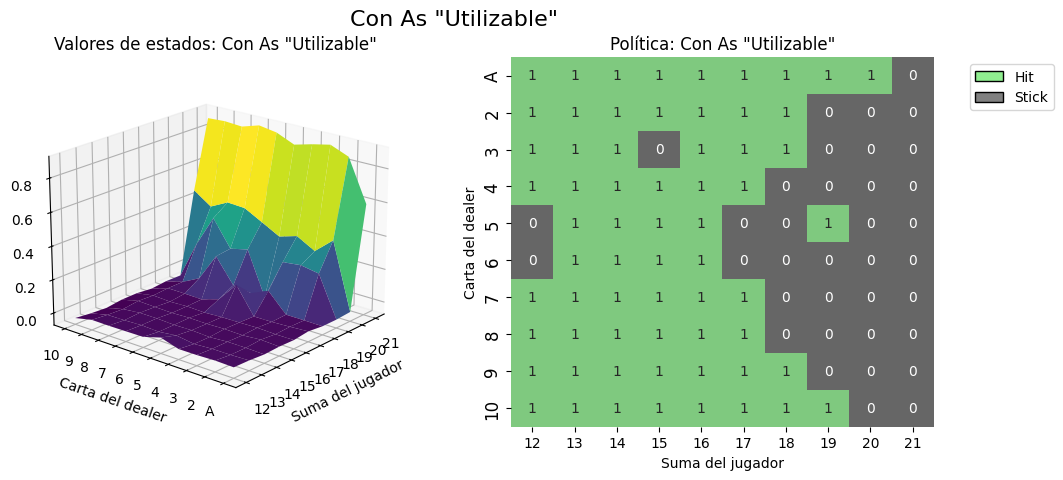

In [17]:
def create_grids(agent, usable_ace = False):
    """Create value and policy grid given an agent."""
    # convertir los valores Q en valores de estado (un promedio total)
    # y crear un diccionario de políticas que sirve para relacionar observaciones con acciones
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # cartas del jugador y del dealer
        np.arange(12, 22),
        np.arange(1, 11))

    # crear una tabla de valores
    value = np.apply_along_axis(lambda obs: state_value[(obs[0], obs[1], usable_ace)],
                                axis = 2,
                                arr = np.dstack([player_count, dealer_count]))
    value_grid = player_count, dealer_count, value

    # crear una tabla de políticas
    policy_grid = np.apply_along_axis(lambda obs: policy[(obs[0], obs[1], usable_ace)],
                                      axis=2,
                                      arr=np.dstack([player_count, dealer_count]))
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # el lado izquierdo son valores de estado y el derecho, políticas
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # valores de estado
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(player_count,
                     dealer_count,
                     value,
                     rstride=1,
                     cstride=1,
                     cmap="viridis",
                     edgecolor="none",)
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"Valores de estados: {title}")
    ax1.set_xlabel("Suma del jugador")
    ax1.set_ylabel("Carta del dealer")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # políticas
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Política: {title}")
    ax2.set_xlabel("Suma del jugador")
    ax2.set_ylabel("Carta del dealer")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # leyenda
    legend_elements = [Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
                       Patch(facecolor="grey", edgecolor="black", label="Stick")]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# valores de estado y políticas cuando hay as utilizable (as sirve como 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title='Con As "Utilizable"')
plt.show()

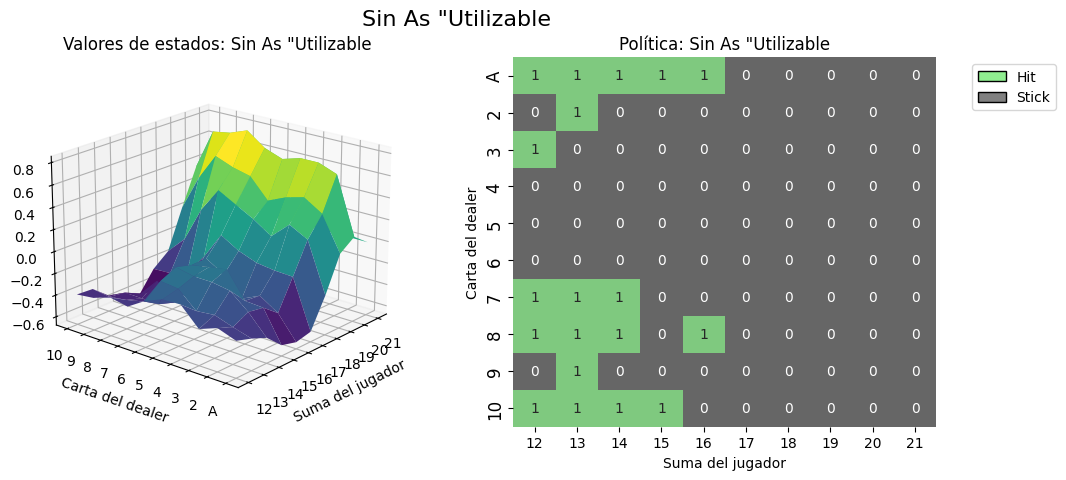

In [18]:
# valores de estado y políticas cuando no hay as utilizable
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title='Sin As "Utilizable')
plt.show()

In [19]:
env.close()

# SARSA (State-Action-Reward-State-Action)

SARSA es un algoritmo de aprendizaje por refuerzo que guía a un agente en un entorno interactivo. Ajusta sus estrategias basándose en experiencias reales, considerando las acciones tomadas, recompensas obtenidas y futuros estados previstos. Esto lo hace adecuado para entornos donde la cautela y la adaptación gradual son esenciales.

Este algoritmo elige acciones basándose en alguna política actual y ajusta su comportamiento considerando las acciones futuras bajo esa política. En cambio, Q-Learning busca la acción que maximiza el valor futuro sin preocuparse por la política actual, tomando decisiones de manera más independiente y quizás más arriesgada.

$$
Q[state,action]=Q[state,action]+α⋅(reward+γ⋅Q[new_state,new_action]−Q[state,action])
$$

# Frozen Lake

https://gymnasium.farama.org/environments/toy_text/frozen_lake/#action-space

<div style="text-align:center">
    <img src="https://gymnasium.farama.org/_images/frozen_lake.gif">
</div>

## Funcionamiento

In [20]:
env = gym.make('FrozenLake-v1', is_slippery=True, 
            #    render_mode = 'human',
               # desc = sirve para hacer un mapa personalizado
               )
observation, info = env.reset()

In [21]:
observation # representa el estado (0 = estado inicial)

0

In [22]:
info # representa la probabilidad de éxito de la acción, puesto que el hielo es resbaladizo. (al hacer reset siempre será 1)

{'prob': 1}

In [23]:
env.action_space

Discrete(4)

* 0: Izquierda

* 1: Abajo

* 2: Derecha

* 3: Arriba

In [ ]:
# env.render()

In [ ]:
# observation, reward, terminated, truncated, info = env.step(3)

## Agente

In [24]:
# Hiperparámetros

alpha = 0.9
gamma = 0.9
epsilon = 1
epsilon_decay_rate = 0.0001

In [25]:
# Estados y Q-Table

n_states = env.observation_space.n # n representa el número total de distintos estados
n_actions = env.action_space.n
Q = pd.DataFrame(np.zeros((n_states, n_actions)))
Q


,0,1,2,3
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0


In [26]:
Q.shape

(16, 4)

In [27]:
# Política 

def epsilon_greedy(Q, epsilon, n_actions, state):
    if np.random.random() <= epsilon:           # Hay un 10 % de probabilidades de que el agente explore
        return np.random.randint(n_actions)
    else:
        return np.argmax(Q[state, :])           # Del resto, siempre va a escoger el valor más alto de la tabla

## Entrenamiento

In [28]:
def run(episodes, is_training=True, render=False, slippery=False):

    env = gym.make('FrozenLake-v1', is_slippery=slippery, render_mode='human' if render else None)

    n_actions = env.action_space.n
    n_states = env.observation_space.n

    Q = np.zeros((n_states, n_actions))

    alpha = 0.9 
    gamma = 0.9 
    epsilon = 1 
    epsilon_decay_rate = 0.0001 

    rewards_per_episode = np.zeros(episodes)

    for i in tqdm(range(episodes)):
        state = env.reset()[0]  # states: 0 to 63, 0=top left corner,63=bottom right corner
        action = epsilon_greedy(Q, epsilon, n_actions, state)
        terminated = False      # True when fall in hole or reached goal
        truncated = False       # True when actions > 200

        while(not terminated and not truncated):
            new_state, reward, terminated, truncated, _ = env.step(action)
            new_action = epsilon_greedy(Q, epsilon, n_actions, new_state)

            if is_training:
                Q[state, action] += alpha * (reward + gamma * Q[new_state, new_action] - Q[state, action])

            state = new_state
            action = new_action

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        if reward == 1:
            rewards_per_episode[i] = 1

    env.close()

    sum_rewards = np.zeros(episodes)
    for t in range(episodes):
        sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])
    plt.plot(sum_rewards)
    plt.show()

100%|██████████| 15/15 [00:00<00:00, 3375.97it/s]


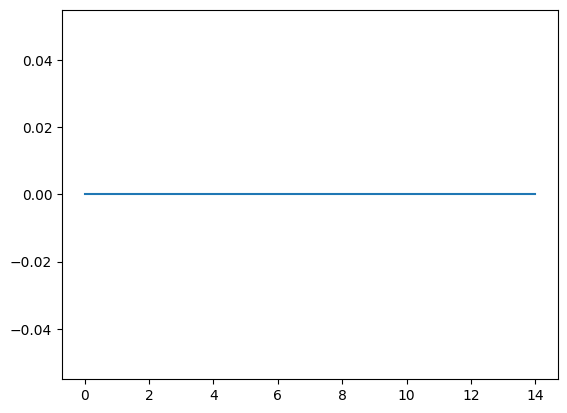

In [29]:
run(15, is_training=True, render=False, slippery=False)

# ¿Cómo se guarda?

In [ ]:
import pickle

def run(episodes, is_training=True, render=False, slippery=False, save_path = None):

    # . . .

    if save_path is not None:
            try:
                with open(save_path, 'rb') as file:
                    Q = pickle.load(file)
                    print(f"Agente cargado desde {save_path}")
            except FileNotFoundError:
                print(f"No se encontró el archivo en la ruta {save_path}. Inicializando nueva tabla Q.")

    if Q is None:
        Q = np.zeros((n_states, n_actions))

    # . . .
